<a href="https://colab.research.google.com/github/manda-24/Personal-Projects/blob/main/New1_BreastCancerDetection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Breast Cancer Detection**

From Research, https://pmc.ncbi.nlm.nih.gov/articles/PMC8840464/#B40-sensors-22-00807, DarkNet53 was determined as a very good pre-trained deep model for this purpose. THus, using this model as the baseline and training it on augmented ultrasound data using transfer learning.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from random import sample
from PIL import Image
import timm.models.vision_transformer
from timm.layers import trunc_normal_
import math
import sys
from typing import Iterable
from timm.utils import accuracy
import datetime
import time
from collections import defaultdict, deque
import torch.distributed as dist
from torch.utils.data import DataLoader, random_split
from torch import nn
from functools import partial
import torch.nn.functional as F
from scipy.io import loadmat
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.utils.data import Dataset
import re
import h5py
from torchvision.transforms import (
    Grayscale, ToTensor, Compose, Resize, InterpolationMode, Normalize, Lambda
)
plt.rcParams['font.family'] = 'serif'
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed
from tensorflow import keras
!pip install tensorflow-model-optimization as tfmot
!pip install --user --upgrade tensorflow-model-optimization



ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as
  Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl.metadata (904 bytes)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 62.3 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


**Prepare the Dataset & Identify Names of Classes** <br>
In this section, the data paths for all three classes (malignant, benign and normal) are defined. Furthermore, the class names are derived from the names of the images.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path= Path('/content/drive/MyDrive/Final Project/Images/Dataset_BUSI_with_GT/Images')

In [4]:
class_names = np.array([item.name for item in dataset_path.glob('*/') if item.is_dir])
print(class_names)

['benign' 'malignant' 'normal']


In [5]:
Image_count = len(list(dataset_path.glob('*/*.png')))
print(Image_count)

11997


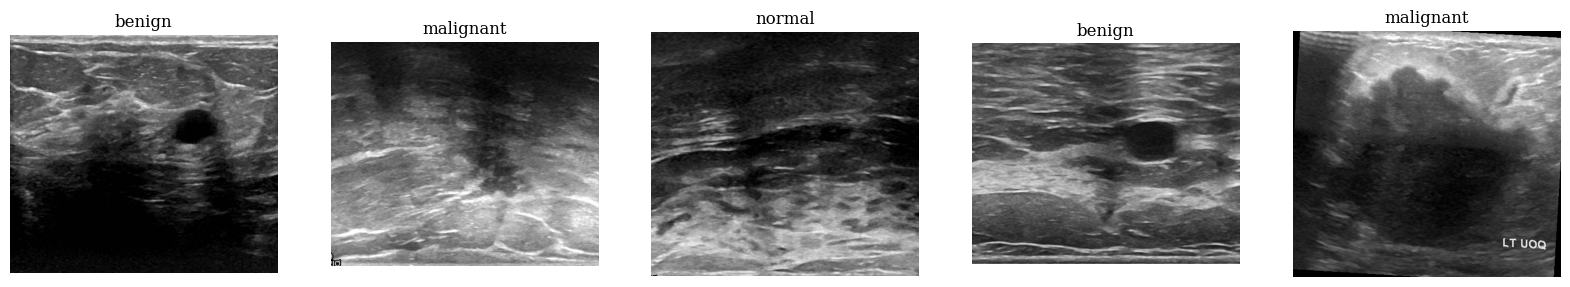

In [6]:
import matplotlib.pyplot as plt
import numpy as np
#Display some images

num_images =5
image_paths = list(dataset_path.glob('*/*.png'))
show_images =np.random.choice(image_paths, size=num_images, replace=False)
fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(20,20))
for i, image_path in enumerate(show_images):
  image = plt.imread(image_path)
  ax[i].imshow(image)
  ax[i].set_title(image_path.parent.name)
  ax[i].axis('off')
plt.show()

**Data Augmentation**
Deep learning requires many data sets. However, it has been a major challenge finding openly available datasets in the medical domain thus the need to augment the images to increase the diversity of the original image.

In [7]:
from torch.utils.data import Dataset, random_split
import torchvision.transforms as transforms
from PIL import Image

class BUSIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.image_paths = list(self.root_dir.glob('*/*.png'))
        self.transform = transform
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_path = Path(image_path)

        image = Image.open(str(image_path)).convert('RGB') # Ensure image_path is a string for PIL.Image.open
        label = self.class_to_idx[image_path.parent.name]

        if self.transform:
            image = self.transform(image)

        return image, label

Only run once!! Already run!!

In [8]:
def augment_data(dataset_path, target_images_per_class=4000):
    """Augments the dataset to reach the target number of images per class.

    Args:
        dataset_path (Path): Path to the dataset.
        target_images_per_class (int): Target number of images per class.

    Returns:
        list: List of augmented image paths.
    """
    dataset_path=Path(dataset_path)
    augmented_image_paths = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            image_paths = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.png')]
            num_images = len(image_paths)
            num_to_augment = target_images_per_class - num_images

            if num_to_augment > 0:
                augmentations = [
                    transforms.RandomHorizontalFlip(p=1),  # Horizontal flip
                    transforms.RandomVerticalFlip(p=1),    # Vertical flip
                    transforms.RandomRotation(90),        # Rotate 90 degrees
                ]
                for _ in range(num_to_augment):
                    # Randomly select an image and augmentation
                    original_image_path = np.random.choice(image_paths)
                    augmentation = np.random.choice(augmentations)

                    # Load, transform, and save the augmented image
                    image = Image.open(original_image_path).convert('RGB')
                    augmented_image = augmentation(image)
                    new_image_path = os.path.join(class_path, f"augmented_{len(augmented_image_paths) + 1}.png")
                    augmented_image.save(new_image_path)
                    #Append path object not string
                    augmented_image_paths.append(Path(new_image_path))

    return augmented_image_paths


dataset = BUSIDataset(dataset_path)

# Augment the data
augmented_image_paths = augment_data(dataset_path)

# Update the dataset with augmented images
dataset.image_paths.extend(augmented_image_paths)

In [9]:
dataset = BUSIDataset(dataset_path)
# Update the dataset with augmented images
total_images = len(dataset)
print("Total number of images after image augmentation:", total_images)

Total number of images after image augmentation: 11997


In [10]:
from torchvision import transforms

# ... (Your other imports and code) ...


# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),  # Resize to a common size
    transforms.ToTensor(),                             # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet means and stds
                         std=[0.229, 0.224, 0.225])
])


# ... (Rest of your code, including the BUSIDataset and dataset creation) ...

In [11]:

#Split the data into testing and validation sets
dataset = BUSIDataset(dataset_path, transform=transform)
seed =42
train_test_split = 0.8
dataset_train, dataset_val = random_split(dataset, [int(len(dataset) * train_test_split), len(dataset) - int(len(dataset) * train_test_split)],
                                          generator=torch.Generator().manual_seed(seed))

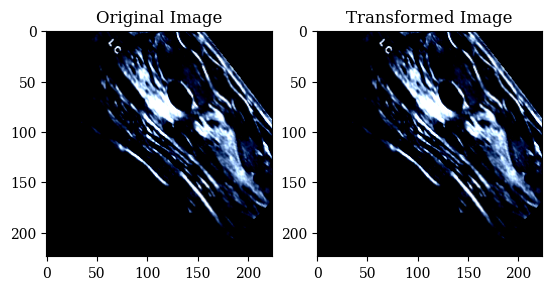

In [12]:
#Show how the image is being transformed

import matplotlib.pyplot as plt

# Get a sample image and its label
image, label = dataset[0]

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))  # Permute to change the channel order for display
plt.title("Original Image")

# Apply the transformations again to the sample image
transformed_image = transform(Image.open(dataset.image_paths[0]).convert('RGB'))

# Display the transformed image
plt.subplot(1, 2, 2)
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title("Transformed Image")

plt.show()

In [13]:
from torch.utils.data import Dataset, random_split
import torchvision.transforms as transforms
from PIL import Image

class BUSIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.image_paths = list(self.root_dir.glob('*/*.png'))
        self.transform = transform
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_path = Path(image_path)
        # Attempt to open the image, handle potential errors
        try:
            image = Image.open(str(image_path)).convert('RGB')  # Ensure image_path is a string for PIL.Image.open
            #Verify image is not truncated
            image.load() #This will force the image to load and raise an exception if truncated

        except (IOError, OSError) as e:
            print(f"Error opening image: {image_path}, error: {e}")
            # You might want to skip this image or handle it differently
            # For now, let's return a black image as a placeholder
            image = Image.new('RGB', (224, 224), color='black')

            # Log or remove corrupted images:
            # with open('corrupted_images.txt', 'a') as f:
            #     f.write(str(image_path) + '\n')
            # self.image_paths.pop(idx)  # Remove the corrupted image from the list

            # Return None to signal a corrupted image, or a black image placeholder
            # return None, None # If you want to skip the corrupted image entirely

        label = self.class_to_idx[image_path.parent.name]

        if self.transform:
            image = self.transform(image)

        return image, label

In [14]:
import numpy as np
from torch.utils.data import DataLoader

# Function to convert PyTorch dataset to NumPy arrays
def convert_to_numpy(dataset, batch_size=128):
    images = []
    labels = []

    # Use DataLoader for efficient batch processing
    dataloader = DataLoader(dataset, batch_size=batch_size)

    for batch in dataloader:
        image_batch, label_batch = batch
        images.append(image_batch.numpy())  # Convert batch of images to NumPy
        labels.append(label_batch.numpy())  # Convert batch of labels to NumPy

    # Concatenate all batches into single NumPy arrays
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

    return images, labels

# Convert training dataset to NumPy arrays
train_images, train_labels = convert_to_numpy(dataset_train)

# Convert validation dataset to NumPy arrays
val_images, val_labels = convert_to_numpy(dataset_val)

# Transpose the dimensions of the images (from PyTorch format to TensorFlow format)
train_images = np.transpose(train_images, (0, 2, 3, 1))  # (N, H, W, C)
val_images = np.transpose(val_images, (0, 2, 3, 1))      # (N, H, W, C)

# Print the number of samples in training and validation datasets
print(len(train_images))
print(len(val_images))


9597
2400


In [14]:
import numpy as np

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



# Convert PyTorch dataset to NumPy arrays to use Tensorflow.keras
train_images = []
train_labels = []

for image, label in dataset_train:
    image = image.cpu()  # Move tensor to CPU if necessary
    train_images.append(image.numpy())
    train_labels.append(label)

for image, label in dataset_train:
    train_images.append(image.numpy())  # Convert image tensor to NumPy array
    train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

#In order for the images
train_images = np.transpose(train_images, (0, 2, 3, 1))

val_images = []
val_labels = []
for image, label in dataset_val:
    val_images.append(image.numpy())
    val_labels.append(label)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

# **Transpose the dimensions of the validation images**
val_images = np.transpose(val_images, (0, 2, 3, 1))

print(len(train_images))
print(len(val_images))

KeyboardInterrupt: 

**Model Development**

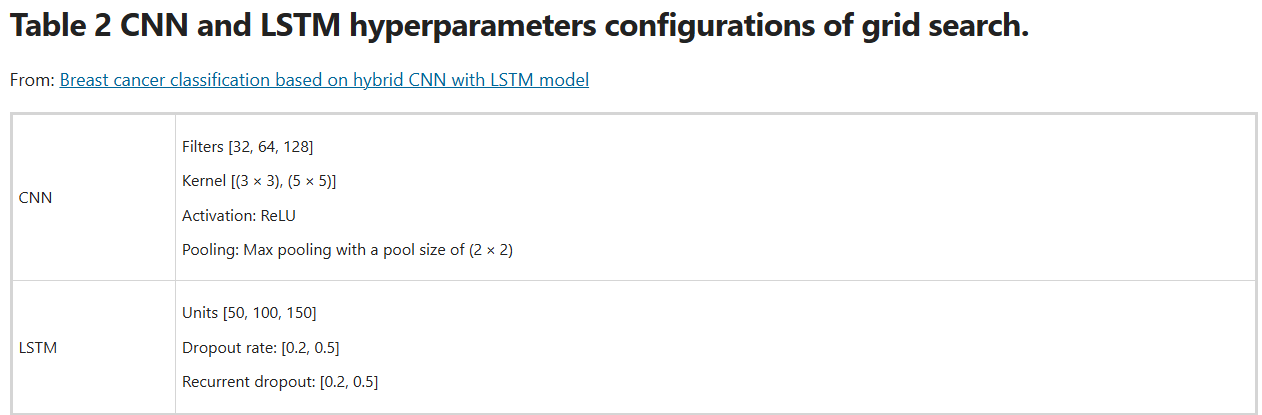

In [15]:
batch_size =16
num_workers = 2

In [103]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed
import tensorflow as tf #Add this import

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers,
                               pin_memory=True, drop_last=True)

# Define the hybrid CNN-LSTM model
def create_model():
    model = tf.keras.models.Sequential() # Create an instance of the Sequential class

    # CNN layers
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(None, 224, 224, 3)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Conv2D(128, (5, 5), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    # LSTM layers
    model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
    model.add(LSTM(150, dropout=0.5, recurrent_dropout=0.5))

    # Fully connected layer
    model.add(Dense(3, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = create_model()

# Summary of the model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_9 (TimeDistributed) │ (None, None, 222, 222, 32)  │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, None, 111, 111, 32)  │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, None, 109, 109, 64)  │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, None, 54, 54, 64)    │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, None, 50, 50, 128)   │         204,928 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, None, 25, 25, 128)   │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, None, 80000)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 50)            │      16,010,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 150)                 │         150,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,445,973 (62.74 MB)

 Trainable params: 16,445,973 (62.74 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
import numpy as np

# Convert EagerTensors to NumPy arrays before reshaping
train_images_np = train_images.numpy()
val_images_np = val_images.numpy()

# Reshape the NumPy arrays to add a time dimension
train_images = train_images_np.reshape(-1, 1, 224, 224, 3)
val_images = val_images_np.reshape(-1, 1, 224, 224, 3)

import tensorflow as tf
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Convert reshaped NumPy arrays back to TensorFlow tensors
with tf.device('/cpu:0'):
    train_images = tf.convert_to_tensor(train_images, np.float32)
    train_labels = tf.convert_to_tensor(train_labels, np.float32)
    val_images = tf.convert_to_tensor(val_images, np.float32)
    val_labels = tf.convert_to_tensor(val_labels, np.float32)

history = model.fit(train_images, train_labels, epochs=20,
                    validation_data=(val_images, val_labels))

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.4021 - loss: 1.0826 - val_accuracy: 0.4762 - val_loss: 0.9851
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.5407 - loss: 0.9444 - val_accuracy: 0.5629 - val_loss: 0.9194
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.6807 - loss: 0.7681 - val_accuracy: 0.8046 - val_loss: 0.5353
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8239 - loss: 0.4709 - val_accuracy: 0.8629 - val_loss: 0.3558
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8918 - loss: 0.2925 - val_accuracy: 0.9038 - val_loss: 0.2625
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9371 - loss: 0.1765 - val_accuracy: 0.9158 - val_loss: 0.2663
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9534 - loss: 0.1332 - val_accuracy: 0.9217 - val_loss: 0.2455
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.9701 - loss: 0.0899 - 

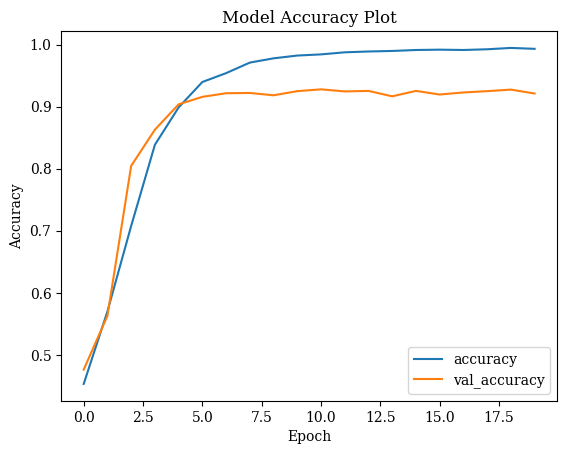

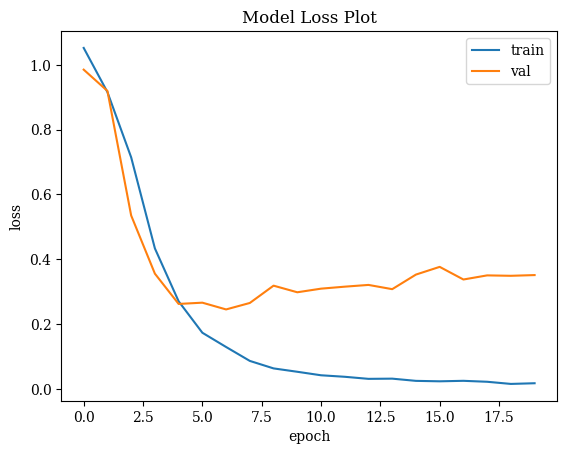

In [106]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [107]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1. Make predictions on the validation set:
with tf.device('/cpu:0'):  # Move prediction to CPU if needed
    predictions = model.predict(val_images)

# 2. Convert predictions to class labels:
predicted_labels = np.argmax(predictions, axis=1)

# 3. Calculate and print the classification report:
print(classification_report(val_labels, predicted_labels, target_names=dataset.classes))

75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step
              precision    recall  f1-score   support

      benign       0.90      0.89      0.89       788
   malignant       0.92      0.93      0.92       778
      normal       0.95      0.95      0.95       834

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400



75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9174 - loss: 0.3330
0.3514516055583954
0.9212499856948853
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


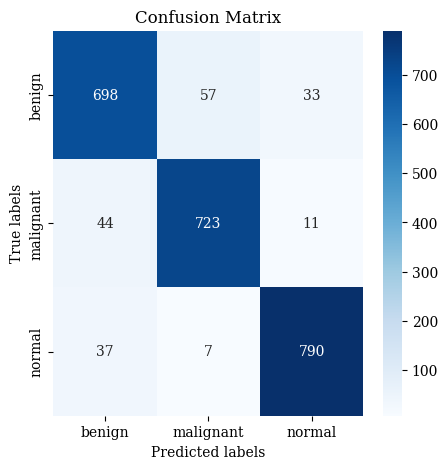

In [108]:

import matplotlib.pyplot as plt
import seaborn as sns

loss, acc = model.evaluate(val_images, val_labels)
print(loss)
print(acc)
label_pred=model.predict(val_images)
label_pred_labels = np.argmax(label_pred, axis=1)


# Define class labels
classes = ['benign', 'malignant', 'normal']

# Generate confusion matrix
conf_matrix = confusion_matrix(val_labels, label_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

In [111]:
# Save your trained model
model.save('breastcancerdetection.keras')
model.save('/content/drive/MyDrive/Final Project/Models/breastcancerdetection.keras')

Pruning

In [110]:
import tensorflow as tf
!pip uninstall tensorflow-model-optimization -y
!pip install tensorflow-model-optimization
!pip show tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
import numpy as np
import tempfile

Found existing installation: tensorflow-model-optimization 0.8.0
Uninstalling tensorflow-model-optimization-0.8.0:
  Successfully uninstalled tensorflow-model-optimization-0.8.0
  Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl.metadata (904 bytes)
Using cached tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl (242 kB)


Name: tensorflow-model-optimization
Version: 0.8.0
Summary: A suite of tools that users, both novice and advanced can use to optimize machine learning models for deployment and execution.
Home-page: https://github.com/tensorflow/model-optimization
Author: Google LLC
Author-email: no-reply@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, dm-tree, numpy, six
Required-by: 


In [112]:
for layer in model.layers:
    print(layer.name, type(layer))

time_distributed_9 <class 'keras.src.layers.rnn.time_distributed.TimeDistributed'>
time_distributed_10 <class 'keras.src.layers.rnn.time_distributed.TimeDistributed'>
time_distributed_11 <class 'keras.src.layers.rnn.time_distributed.TimeDistributed'>
time_distributed_12 <class 'keras.src.layers.rnn.time_distributed.TimeDistributed'>
time_distributed_13 <class 'keras.src.layers.rnn.time_distributed.TimeDistributed'>
time_distributed_14 <class 'keras.src.layers.rnn.time_distributed.TimeDistributed'>
time_distributed_15 <class 'keras.src.layers.rnn.time_distributed.TimeDistributed'>
lstm_3 <class 'keras.src.layers.rnn.lstm.LSTM'>
lstm_4 <class 'keras.src.layers.rnn.lstm.LSTM'>
lstm_5 <class 'keras.src.layers.rnn.lstm.LSTM'>
dense_1 <class 'keras.src.layers.core.dense.Dense'>


In [127]:
!pip install -q tensorflow-model-optimization
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras

%load_ext tensorboard
print(tf.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.18.0


In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed

In [129]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras import layers

In [97]:
!pip install torch==1.13.0 torchvision==0.15.1

  Using cached torch-1.13.0-cp311-cp311-manylinux1_x86_64.whl.metadata (24 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==1.13.0 and torchvision==0.15.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==1.13.0
    torchvision 0.15.1 depends on torch==2.0.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [133]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed
import tensorflow_model_optimization as tfmot
import numpy as np

# Define the hybrid CNN-LSTM model
def create_model():
    model = tf.keras.models.Sequential() # Create an instance of the Sequential class

    # CNN layers
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(None, 224, 224, 3)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Conv2D(128, (5, 5), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    # LSTM layers
    model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
    model.add(LSTM(150, dropout=0.5, recurrent_dropout=0.5))

    # Fully connected layer
    model.add(Dense(3, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = create_model()

# Summary of the model
model.summary()

# Pruning parameters
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.50,
        final_sparsity=0.80,
        begin_step=0,
        end_step=end_step
    )
}

# Apply pruning directly to the model
model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model_for_pruning.summary()


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_37                  │ (None, None, 222, 222, 32)  │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_38                  │ (None, None, 111, 111, 32)  │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_39                  │ (None, None, 109, 109, 64)  │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_40                  │ (None, None, 54, 54, 64)    │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_41                  │ (None, None, 50, 50, 128)   │         204,928 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_42                  │ (None, None, 25, 25, 128)   │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_43                  │ (None, None, 80000)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, None, 50)            │      16,010,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 150)                 │         150,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,445,973 (62.74 MB)

 Trainable params: 16,445,973 (62.74 MB)

 Non-trainable params: 0 (0.00 B)

ValueError: `prune_low_magnitude` can only prune an object of the following types: keras.models.Sequential, keras functional model, keras.layers.Layer, list of keras.layers.Layer. You passed an object of type: Sequential.

Finetune pruned model

In [134]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

ValueError: You must call `compile()` before using the model.

In [135]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
stripped_pruned_model.save('pruned_breastcancerdetection.h5')

ValueError: ('Expected model to be a `keras.Model` instance but got: ', <Sequential name=sequential_16, built=False>)

In [136]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_model)

NameError: name 'stripped_pruned_model' is not defined

In [137]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('breastcancerdetection.h5')
pruned_model = tf.keras.models.load_model('pruned_breastcancerdetection.h5')
val_loss, val_acc = model.evaluate(val_images,  val_labels, verbose=0)
val_loss_pruned_50, val_acc_pruned_50 = pruned_model.evaluate(val_images,  val_labels, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(val_images)
executionTime = (time.time() - startTime)/len(val_images)

startTime = time.time()
prediction = pruned_model.predict(val_images)
executionTimePruned50 = (time.time() - startTime)/len(val_images)

base_model_size = get_gzipped_model_size('breastcancerdetection.h5')
## Print without stripping
pruned_model_size = get_gzipped_model_size('pruned_breastcancerdetection.h5')

# Print
print('\nBase Model Accuracy:', val_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', val_acc_pruned_50*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned50, "s")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'pruned_breastcancerdetection.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Quantization

In [139]:
import tensorflow as tf

model_to_quantize = tf.keras.models.load_model('breastcancerdetection.h5')
model_to_quantize.summary()

# Passing the Keras model to the TFLite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
# Setting the deault optimizer
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Enable resource variables
converter.experimental_enable_resource_variables = True

# Use Select TF ops and disable `_experimental_lower_tensor_list_ops` flag
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

# To convert to 16-bit floating point for example
# converter.target_spec.supported_types = [tf.float16]
# Convert the model
quantized_tflite_model = converter.convert()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_9 (TimeDistributed) │ (None, None, 222, 222, 32)  │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, None, 111, 111, 32)  │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, None, 109, 109, 64)  │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, None, 54, 54, 64)    │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, None, 50, 50, 128)   │         204,928 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, None, 25, 25, 128)   │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, None, 80000)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 50)            │      16,010,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 150)                 │         150,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,445,975 (62.74 MB)

 Trainable params: 16,445,973 (62.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Saved artifact at '/tmp/tmpzy4v9963'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134248343237072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134248343235152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134247451849552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134247451848592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134247451849168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134247451847824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134247451841680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134247451849936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134247451845520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134247451846096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1342474

In [140]:
# Save TFLite Model
with open('quantized_tflite_model.tflite', 'wb') as f:
  f.write(quantized_tflite_model)
# Load model into interpeter
interpreter_quant = tf.lite.Interpreter(model_path=str('quantized_tflite_model.tflite'))
interpreter_quant.allocate_tensors()

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
import zipfile
import time

def evaluate_model(interpreter, model_path):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []

  #Calculate start time here before the loop
  startTime = time.time()
  for val_image in val_images: # changed val_images_image to val_image
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(val_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

    def get_gzipped_model_size(file):
        # Returns size of gzipped model, in bytes.
        _, zipped_file = tempfile.mkstemp('.zip')
        with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
            f.write(file)

        return os.path.getsize(zipped_file)

  # Calculate Execution Time: outside the loop to include all prediction times in the average
  executionTime = (time.time() - startTime)/len(val_images)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == val_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  model_size = get_gzipped_model_size(model_path)
  # Print
  print('\nModel Accuracy:', accuracy*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is", executionTime, "s")
  return accuracy, model_size, executionTime

evaluate_model(interpreter_quant, 'quantized_tflite_model.tflite')